<a href="https://colab.research.google.com/github/mansivv9/GAN_MAJOR_PROJECT/blob/main/texttoimagegan_ms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vvmansi","key":"811c501ee14b7fa4a9cc2a66c3ea44b3"}'}

In [2]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d vvmansi/preprocessed-captions -p /content/sample_data/ --unzip

 91% 11.0M/12.0M [00:01<00:00, 11.6MB/s]
100% 12.0M/12.0M [00:01<00:00, 9.16MB/s]


In [4]:
!kaggle datasets download -d vvmansi/preprocessed-images -p /content/sample_data/ --unzip

100% 335M/336M [00:18<00:00, 20.7MB/s]
100% 336M/336M [00:18<00:00, 19.2MB/s]


In [5]:
!kaggle datasets download -d vvmansi/word2vecpretrainedmodel -p /content/sample_data/ --unzip

100% 1.64G/1.64G [01:21<00:00, 26.9MB/s]
100% 1.64G/1.64G [01:21<00:00, 21.6MB/s]


In [6]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [ ]:
import pickle
import gensim
data = pickle.load(open("/content/sample_data/image_vectors.p", "rb"))
word_vector = pickle.load(open("/content/sample_data/word_vector_min_bird.p", "rb"))
model = gensim.models.KeyedVectors.load_word2vec_format('/content/sample_data/GoogleNews-vectors-negative300.bin', binary=True)

11840
11840
Forsters_Tern_0062_151780.jpg
Forsters_Tern_0062_151780.jpg
Forsters_Tern_0002_151622.jpg
Forsters_Tern_0057_151570.jpg
Forsters_Tern_0109_152094.jpg
Forsters_Tern_0099_152529.jpg
Forsters_Tern_0027_151456.jpg
Forsters_Tern_0032_151384.jpg
Forsters_Tern_0095_152067.jpg


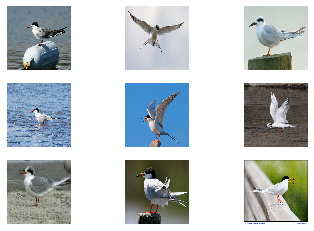

In [ ]:

import matplotlib.pyplot as pyplot
from keras.preprocessing.image import array_to_img
from numpy import expand_dims
from random import randint, choice

def random_flip(image):
  image = tf.image.flip_left_right(image)
  return image.numpy()

def random_jitter(image):

  image = expand_dims(image, 0) #add additional dimension necessary for zooming
  image = image_augmentation_generator.flow(image, batch_size=1)
  result = image[0].reshape(image[0].shape[1:]) #remove additional dimension (1, 64, 64, 3) to (64, 64, 3)
  return result

image_augmentation_generator = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.8, 1.0]) # random zoom proves to be helpful in capturing more details https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

n = 227
image_embeddings = []
captions = []
labels = []
for i, k in enumerate(data.keys()):
  image_embeddings.append(data[k])
  captions.append(word_vector[k])
  labels.append(k)
  if i % n == 0:
   image_embeddings.append(random_jitter(data[k]))
   captions.append(word_vector[k])
   labels.append(k)

print(len(captions))
print(len(image_embeddings))

pyplot.axis('off')
slcie = image_embeddings[40:50]
for i in range(9):
  pyplot.subplot(3, 3, i+1)
  pyplot.imshow(array_to_img(slcie[i]))
  print(labels[i])
  pyplot.axis('off')

pyplot.show()

In [ ]:
import numpy as np

def get_random_word_vectors_from_dataset(n_samples):
  ix = np.random.randint(0, len(captions), n_samples)
  return np.asarray(captions)[ix]


In [ ]:

def generate_random_vectors(n_samples):  
  vectorized_random_captions = []

  for n in range(n_samples):
    rnd = randint(8, 25)
    result_array = np.empty((0, 300))
    for i in range(rnd):
      result_array = np.append(result_array, [model[choice(model.index_to_key)]], axis=0)
    vectorized_random_captions.append(np.mean(result_array, axis=0).astype('float32'))

  return np.array(vectorized_random_captions)


In [ ]:
from keras.preprocessing.image import array_to_img

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy import asarray
import numpy as np

import os
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from numpy.random import random
from tensorflow.keras import layers
from tensorflow.keras import Model
from numpy.random import randn
from numpy.random import randint
import time
from keras.layers.advanced_activations import PReLU
from keras.utils.vis_utils import plot_model

# Discriminator model
def define_discriminator():
    word_vector_dim = 300
    dropout_prob = 0.4

    in_label = layers.Input(shape=(300,))

    n_nodes = 3 * 64 * 64
    li = layers.Dense(n_nodes)(in_label)
    li = layers.Reshape((64, 64, 3))(li)

    dis_input = layers.Input(shape=(64, 64, 3))

    merge = layers.Concatenate()([dis_input, li])

    discriminator = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same")(merge)
    discriminator = layers.LeakyReLU(0.2)(discriminator)
    discriminator = layers.GaussianNoise(0.2)(discriminator)

    discriminator = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU()(discriminator)

    discriminator = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Flatten()(discriminator)

    discriminator = layers.Dense(1024)(discriminator)

    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Dense(1)(discriminator)

    discriminator_model = Model(inputs=[dis_input, in_label], outputs=discriminator)

    discriminator_model.summary()

    return discriminator_model


def resnet_block(model, kernel_size, filters, strides):
    gen = model
    model = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding="same")(model)
    model = layers.BatchNormalization(momentum=0.5)(model)
    model = tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(model)
    model = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding="same")(model)
    model = layers.BatchNormalization(momentum=0.5)(model)
    model = layers.Add()([gen, model])
    return model


# Generator model
def define_generator():
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    batch_init = tf.random_normal_initializer(1., 0.02)

    random_input = layers.Input(shape=(100,))
    text_input1 = layers.Input(shape=(300,))
    text_layer1 = layers.Dense(8192)(text_input1)
    text_layer1 = layers.Reshape((8, 8, 128))(text_layer1)

    n_nodes = 128 * 8 * 8
    gen_input_dense = layers.Dense(n_nodes)(random_input)
    generator = layers.Reshape((8, 8, 128))(gen_input_dense)

    merge = layers.Concatenate()([generator, text_layer1])

    model = layers.Conv2D(filters=64, kernel_size=9, strides=1, padding="same")(merge)
    model = tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(model)

    gen_model = model

    for _ in range(4):
      model = resnet_block(model, 3, 64, 1)

    model = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(model)
    model = layers.BatchNormalization(momentum=0.5)(model)
    model = layers.Add()([gen_model, model])

    model = layers.Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)(model)
    model = layers.LeakyReLU(0.2)(model)

    model = layers.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)(model)
    model = layers.LeakyReLU(0.2)(model)

    model = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)(model)
    model = layers.LeakyReLU(0.2)(model)

    model = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer=kernel_init)(model)
    model = layers.LeakyReLU(0.2)(model)

    model = layers.Conv2D(3, (3, 3), padding='same', activation='tanh')(model)

    generator_model = Model(inputs=[random_input, text_input1], outputs=model)

    generator_model.summary()

    return generator_model

In [ ]:
from IPython.display import clear_output


def generate_latent_points(latent_dim, n_samples):
    x_input  = tf.random.normal([n_samples, latent_dim])
    text_captions = get_random_word_vectors_from_dataset(n_samples)
    return [x_input, text_captions]

# Randomly flip some labels. Credits to https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/
def noisy_labels(y, p_flip):
    n_select = int(p_flip * int(y.shape[0]))
    flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)

    op_list = []
    for i in range(int(y.shape[0])):
        if i in flip_ix:
            op_list.append(tf.subtract(1.0, y[i]))
        else:
            op_list.append(y[i])

    outputs = tf.stack(op_list)
    return outputs

def load_data():
    return asarray(image_embeddings), asarray(captions).astype('float32')

def smooth_positive_labels(y):
	return y - 0.3 + (np.random.random(y.shape) * 0.5)
 
def smooth_negative_labels(y):
	return y + np.random.random(y.shape) * 0.3

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  print(predictions.shape)
  pyplot.figure(figsize=[7, 7])

  for i in range(predictions.shape[0]):
      pyplot.subplot(5, 5, i+1)
      pyplot.imshow(array_to_img(predictions.numpy()[i]))
      pyplot.axis('off')

  pyplot.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  pyplot.show()


def discriminator_loss(r_real_output_real_text, f_fake_output_real_text_1, f_real_output_fake_text):
   alpha = 0.5
   real_output_noise = smooth_positive_labels(noisy_labels(tf.ones_like(r_real_output_real_text), 0.10))
   fake_output_real_text_noise_1 = smooth_negative_labels(tf.zeros_like(f_fake_output_real_text_1))
   real_output_fake_text_noise = smooth_negative_labels(tf.zeros_like(f_real_output_fake_text))

   real_loss = tf.reduce_mean(binary_cross_entropy(real_output_noise, r_real_output_real_text))
   fake_loss_ms_1 = tf.reduce_mean(binary_cross_entropy(fake_output_real_text_noise_1, f_fake_output_real_text_1))
   fake_loss_2 = tf.reduce_mean(binary_cross_entropy(real_output_fake_text_noise, f_real_output_fake_text))

   total_loss = real_loss + alpha * fake_loss_2 + (1-alpha) * fake_loss_ms_1 
   return total_loss

def generator_loss(f_fake_output_real_text):
   return tf.reduce_mean(binary_cross_entropy(tf.ones_like(f_fake_output_real_text), f_fake_output_real_text))

@tf.function
def train_step(images, epoch):

  #define half_batch
  latent_dim = 100
  n_batch = 64

  noise_1 = tf.random.normal([32, latent_dim])
  noise_2 = tf.random.normal([32, latent_dim])
  real_captions = images[1]
  real_images = images[0]

  random_captions = generate_random_vectors(n_batch)
  random_captions_1, random_captions_2  = tf.split(random_captions, 2, 0)
  real_captions_1, real_captions_2  = tf.split(real_captions, 2 ,0)
  real_images_1, real_images_2 = tf.split(real_images, 2, 0)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    noise = tf.concat([noise_1, noise_2], 0)

    generated_images = generator([noise, real_captions], training=True)

    fake_1, fake_2 = tf.split(generated_images, 2, 0)

    f_fake_output_real_text_1 = discriminator([fake_1, real_captions_1], training=True)
    f_fake_output_real_text_2 = discriminator([fake_2, real_captions_2], training=True)

    r_real_output_real_text_1 = discriminator([real_images_1, real_captions_1], training=True)
    r_real_output_real_text_2 = discriminator([real_images_2, real_captions_2], training=True)

    f_real_output_fake_text_1 = discriminator([real_images_1, random_captions_1], training=True)
    f_real_output_fake_text_2 = discriminator([real_images_2, random_captions_2], training=True)

    #### Calculating losses ####

    gen_loss = generator_loss(f_fake_output_real_text_1) + generator_loss(f_fake_output_real_text_2) 
    # mode seeking loss
    lz = tf.math.reduce_mean(tf.math.abs(fake_2-fake_1)) / tf.math.reduce_mean(tf.math.abs(noise_2-noise_1))
    eps = 1 * 1e-5
    loss_lz = 1 / (eps+lz) * ms_loss_weight
    total_gen_loss = gen_loss + loss_lz

    tf.print('G_loss', [total_gen_loss])

    disc_loss_1 = discriminator_loss(r_real_output_real_text_1, f_fake_output_real_text_1, f_real_output_fake_text_1)
    disc_loss_2 = discriminator_loss(r_real_output_real_text_2, f_fake_output_real_text_2, f_real_output_fake_text_2)
    
    total_disc_loss = disc_loss_1 + disc_loss_2

    tf.print('D_loss', [total_disc_loss])

    #### Done calculating losses ####

  gradients_of_discriminator = disc_tape.gradient(total_disc_loss, discriminator.trainable_variables)  

  gradients_of_generator = gen_tape.gradient(total_gen_loss, generator.trainable_variables)    

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



def train(dataset, epochs = 2000):

  checkpoint_dir = '/kaggle/working/checkpoints_2'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                  generator=generator,
                                  discriminator=discriminator)
  
  ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
  if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)  #ckpt_manager.checkpoints[3]
    print ('Latest checkpoint restored!!')

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch, epoch) 

    if (epoch +1) % 10 == 0:
      [z_input, labels_input] = generate_latent_points(100, 25)
      generate_and_save_images(generator,
                            epoch + 1,
                             [z_input, labels_input])

    if (epoch + 1) % 40 == 0:
      ckpt_save_path = ckpt_manager.save()
      print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

    if (epoch +1) % 60 == 0:
    
      clear_output(wait=True)
      generator.save('/kaggle/working/46stage_new_gan_animal_model_%03d.h5' % (epoch + 1))     

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

ms_loss_weight = 1.0

binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000035, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000035, beta_1 = 0.5)

discriminator = define_discriminator()
generator = define_generator()

images, lbs = load_data()
BUFFER_SIZE = images.shape[0]
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((images,lbs)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train(train_dataset)

2023-01-26 17:31:22.423028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 17:31:22.423978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 17:31:22.577216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 17:31:22.578152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 17:31:22.578924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 12288)        3698688     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 64, 64, 3)    0           dense[0][0]                      
______________________________________________________________________________________________

2023-01-26 17:31:27.975301: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 581959680 exceeds 10% of free system memory.
2023-01-26 17:31:28.645883: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 581959680 exceeds 10% of free system memory.


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[ 9337  5208  3232 10985  3675  3403  8098  2129  3900]
0 White_Necked_Raven_0018_102746.jpg
1 Ovenbird_0070_93140.jpg
2 Rose_Breasted_Grosbeak_0122_39284.jpg
3 Long_Tailed_Jaeger_0016_797084.jpg
4 Ivory_Gull_0035_49523.jpg
5 Brown_Thrasher_0072_155406.jpg
6 Cedar_Waxwing_0066_178719.jpg
7 Tree_Sparrow_0101_124104.jpg
8 Yellow_Billed_Cuckoo_0032_26616.jpg


2023-01-26 17:32:39.968191: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(9, 64, 64, 3)


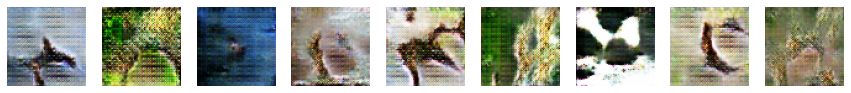

[ 9833 10590   605  6770  4713  7803   290  5692   714]
0 Nelson_Sharp_Tailed_Sparrow_0035_796924.jpg
1 Bank_Swallow_0047_129520.jpg
2 Cape_May_Warbler_0055_163171.jpg
3 Black_Footed_Albatross_0063_796141.jpg
4 Wilson_Warbler_0065_175924.jpg
5 Clay_Colored_Sparrow_0005_110911.jpg
6 Mangrove_Cuckoo_0036_794606.jpg
7 Carolina_Wren_0068_186830.jpg
8 Blue_Grosbeak_0101_36719.jpg
(9, 64, 64, 3)


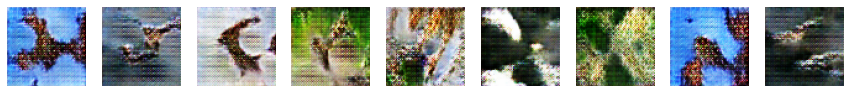

[ 5137 10624  2623  3801 10421  1433  8007  9192  8189]
0 Hooded_Merganser_0092_78989.jpg
1 Bank_Swallow_0022_129923.jpg
2 Acadian_Flycatcher_0028_795611.jpg
3 Philadelphia_Vireo_0024_156645.jpg
4 Western_Gull_0099_53670.jpg
5 Golden_Winged_Warbler_0078_794827.jpg
6 Downy_Woodpecker_0030_184368.jpg
7 Red_Breasted_Merganser_0068_79203.jpg
8 Field_Sparrow_0034_113364.jpg
(9, 64, 64, 3)


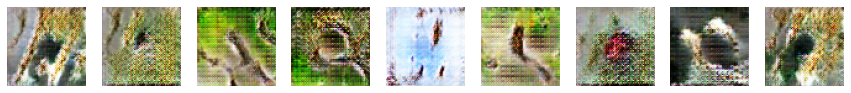

[ 9845  4790  5262  7078  7806  6108 11115  2491  6761]
0 Nelson_Sharp_Tailed_Sparrow_0024_118010.jpg
1 Lazuli_Bunting_0087_15096.jpg
2 White_Eyed_Vireo_0046_158849.jpg
3 Horned_Lark_0139_74492.jpg
4 Chuck_Will_Widow_0014_796987.jpg
5 Brewer_Sparrow_0022_107440.jpg
6 Florida_Jay_0075_65093.jpg
7 Painted_Bunting_0100_16735.jpg
8 Black_Footed_Albatross_0005_796090.jpg
(9, 64, 64, 3)


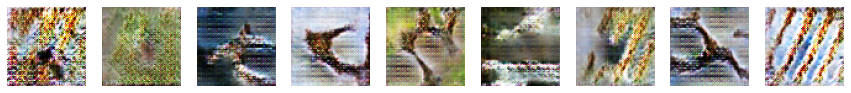

[ 3947   518   720  1894 10332  8353  8543  2345  4430]
0 Yellow_Billed_Cuckoo_0097_26713.jpg
1 Red_Winged_Blackbird_0049_5598.jpg
2 California_Gull_0101_41140.jpg
3 Nighthawk_0045_82807.jpg
4 Savannah_Sparrow_0025_119124.jpg
5 Whip_Poor_Will_0009_796423.jpg
6 Western_Grebe_0086_36478.jpg
7 Chipping_Sparrow_0070_108281.jpg
8 Mockingbird_0016_79605.jpg
(9, 64, 64, 3)


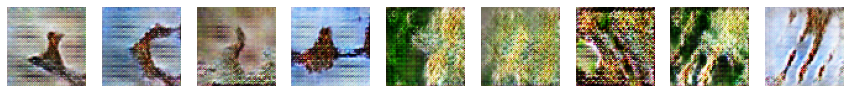

[ 1025  3592  9585  3143  4367 11289  3419  5330  9898]
0 Tree_Swallow_0113_136849.jpg
1 Vesper_Sparrow_0084_125532.jpg
2 Pine_Grosbeak_0048_38434.jpg
3 Ring_Billed_Gull_0132_51552.jpg
4 Black_Tern_0041_144103.jpg
5 Bohemian_Waxwing_0050_796630.jpg
6 Brown_Thrasher_0126_155199.jpg
7 Orange_Crowned_Warbler_0090_167607.jpg
8 Common_Raven_0132_101543.jpg
(9, 64, 64, 3)


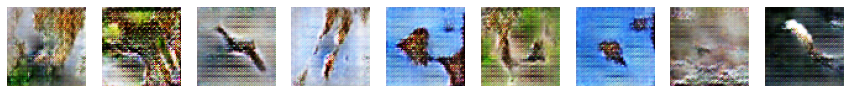

[ 8685  7348  1000 11479  8207  7735  2056  3740  4189]
0 Pigeon_Guillemot_0025_40511.jpg
1 Yellow_Bellied_Flycatcher_0045_42575.jpg
2 Hooded_Oriole_0054_90849.jpg
3 American_Goldfinch_0017_32272.jpg
4 Field_Sparrow_0063_113667.jpg
5 Pied_Kingfisher_0031_71829.jpg
6 Yellow_Breasted_Chat_0017_21719.jpg
7 Scissor_Tailed_Flycatcher_0023_42117.jpg
8 Brown_Creeper_0058_24933.jpg
(9, 64, 64, 3)


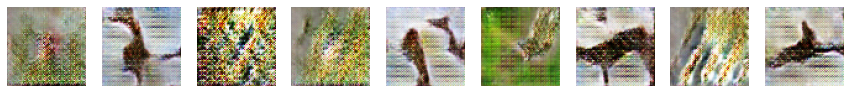

[11383  3520  1412  8361  5409  4775  7709  8851  6181]
0 Marsh_Wren_0040_188252.jpg
1 Red_Faced_Cormorant_0026_796289.jpg
2 Myrtle_Warbler_0083_166738.jpg
3 Whip_Poor_Will_0043_796442.jpg
4 Warbling_Vireo_0009_158721.jpg
5 Lazuli_Bunting_0030_14986.jpg
6 Pied_Kingfisher_0116_71900.jpg
7 American_Three_Toed_Woodpecker_0041_796150.jpg
8 Gray_Kingbird_0006_70268.jpg
(9, 64, 64, 3)


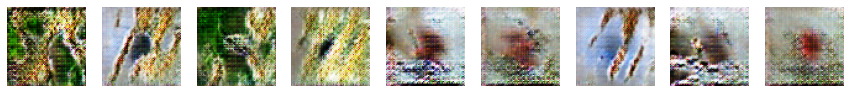

[11561  7187   374 11579 10794 11325  7981 10990  5577]
0 Baird_Sparrow_0036_794572.jpg
1 Laysan_Albatross_0037_699.jpg
2 Prairie_Warbler_0132_172705.jpg
3 Baird_Sparrow_0012_794552.jpg
4 Caspian_Tern_0108_145278.jpg
5 Fox_Sparrow_0054_114541.jpg
6 White_Throated_Sparrow_0039_128859.jpg
7 Long_Tailed_Jaeger_0028_797082.jpg
8 Ringed_Kingfisher_0038_73041.jpg
(9, 64, 64, 3)


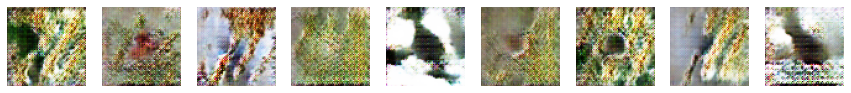

[11097   138  5053  4399  7079  7509  8240 11139  9641]
0 Florida_Jay_0009_64723.jpg
1 Clark_Nutcracker_0076_85083.jpg
2 Groove_Billed_Ani_0069_1546.jpg
3 Mockingbird_0008_81226.jpg
4 Horned_Lark_0013_74374.jpg
5 Cardinal_0014_17389.jpg
6 Kentucky_Warbler_0063_795904.jpg
7 American_Crow_0050_25255.jpg
8 Eastern_Towhee_0093_22621.jpg
(9, 64, 64, 3)


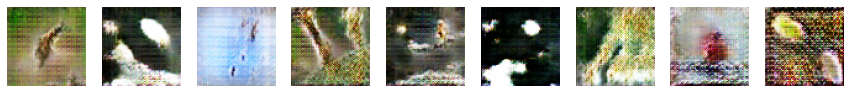

[11671 10389 11169  4665  6557  2416 11701  6911  6960]
0 Horned_Puffin_0035_100690.jpg
1 Pomarine_Jaeger_0029_61365.jpg
2 American_Crow_0016_25112.jpg
3 Blue_Winged_Warbler_0044_161760.jpg
4 Cape_Glossy_Starling_0079_129399.jpg
5 Worm_Eating_Warbler_0011_795566.jpg
6 Horned_Puffin_0045_100803.jpg
7 Mallard_0026_76725.jpg
8 Mallard_0055_77102.jpg
(9, 64, 64, 3)


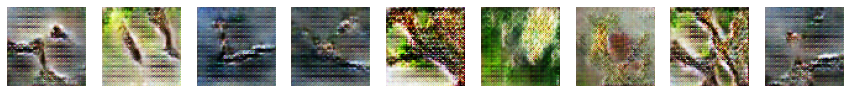

[10710  9478  1179  1633  3998   229  1339   785 10869]
0 Evening_Grosbeak_0004_37960.jpg
1 Sooty_Albatross_0036_796387.jpg
2 Gray_Crowned_Rosy_Finch_0044_26976.jpg
3 Northern_Fulmar_0001_43749.jpg
4 Brandt_Cormorant_0016_23077.jpg
5 Artic_Tern_0127_142440.jpg
6 Swainson_Warbler_0029_794883.jpg
7 Orchard_Oriole_0019_91338.jpg
8 Black_Throated_Sparrow_0076_106995.jpg
(9, 64, 64, 3)


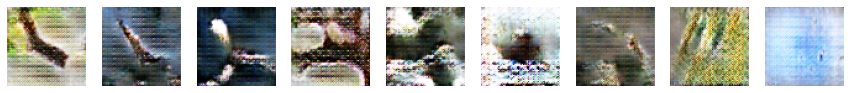

[9607 4616 1120 7878 6487 9918 7110 8476 7634]
0 Pine_Grosbeak_0094_38912.jpg
1 Glaucous_Winged_Gull_0138_44694.jpg
2 Winter_Wren_0050_189514.jpg
3 Summer_Tanager_0097_140042.jpg
4 Vermilion_Flycatcher_0055_42442.jpg
5 Common_Raven_0024_101394.jpg
6 Indigo_Bunting_0059_11596.jpg
7 Northern_Flicker_0072_28678.jpg
8 Pine_Warbler_0022_172197.jpg
(9, 64, 64, 3)


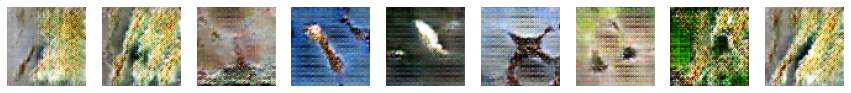

[10786  3056 10252  9177  3964  6875  9567 11727  1586]
0 Caspian_Tern_0068_146615.jpg
1 Black_Billed_Cuckoo_0019_795329.jpg
2 Green_Jay_0036_65660.jpg
3 Red_Breasted_Merganser_0062_79548.jpg
4 Brandt_Cormorant_0061_22902.jpg
5 Chestnut_Sided_Warbler_0001_163813.jpg
6 Pine_Grosbeak_0036_38968.jpg
7 Great_Grey_Shrike_0012_106661.jpg
8 Spotted_Catbird_0019_796788.jpg
(9, 64, 64, 3)


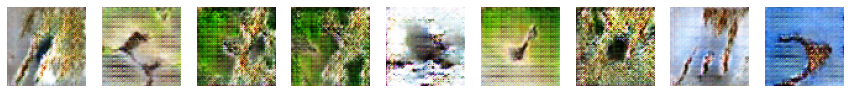

[ 4469 11524  9587 10351  2829 10692   381  4079  3259]
0 House_Wren_0133_187101.jpg
1 Herring_Gull_0068_46392.jpg
2 Pine_Grosbeak_0111_38741.jpg
3 Pomarine_Jaeger_0003_795778.jpg
4 Sage_Thrasher_0092_155482.jpg
5 Elegant_Tern_0096_151068.jpg
6 Prairie_Warbler_0027_172465.jpg
7 Nashville_Warbler_0057_167008.jpg
8 American_Redstart_0055_103750.jpg
(9, 64, 64, 3)


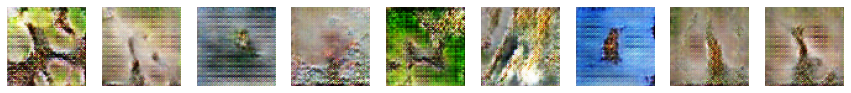

[ 8128  1985  2347   732  8820 10270  3774  2529  4706]
0 Eared_Grebe_0045_34212.jpg
1 Tropical_Kingbird_0086_69759.jpg
2 Chipping_Sparrow_0050_108441.jpg
3 California_Gull_0100_41088.jpg
4 American_Three_Toed_Woodpecker_0015_179827.jpg
5 Green_Jay_0059_65586.jpg
6 Scissor_Tailed_Flycatcher_0025_42032.jpg
7 Painted_Bunting_0077_16819.jpg
8 Blue_Winged_Warbler_0013_161816.jpg
(9, 64, 64, 3)


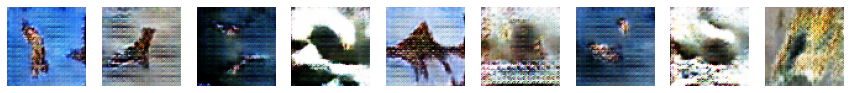

[1303 4597 1571 8151 5609 9332 4127 5787 6980]
0 Le_Conte_Sparrow_0022_117039.jpg
1 Glaucous_Winged_Gull_0136_45059.jpg
2 Spotted_Catbird_0042_19430.jpg
3 Eared_Grebe_0025_34344.jpg
4 Ringed_Kingfisher_0080_72923.jpg
5 White_Necked_Raven_0065_797354.jpg
6 Nashville_Warbler_0115_167039.jpg
7 Sayornis_0106_98841.jpg
8 Yellow_Warbler_0101_176864.jpg
(9, 64, 64, 3)


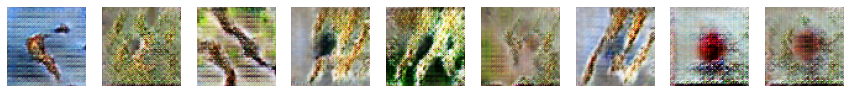

[ 4199  6229  3470  7801  4685 11729 11409   398  7890]
0 Pelagic_Cormorant_0053_23760.jpg
1 Parakeet_Auklet_0001_795972.jpg
2 Harris_Sparrow_0017_116636.jpg
3 Clay_Colored_Sparrow_0040_110717.jpg
4 Blue_Winged_Warbler_0049_161856.jpg
5 Great_Grey_Shrike_0023_106670.jpg
6 Marsh_Wren_0042_188195.jpg
7 Prairie_Warbler_0091_172597.jpg
8 Summer_Tanager_0095_139882.jpg
(9, 64, 64, 3)


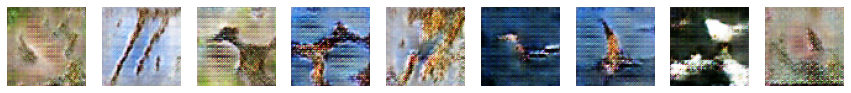

[ 1938  3387  7960  8181  6427  6153  7314  8733 10289]
0 Nighthawk_0088_82225.jpg
1 Brown_Thrasher_0106_155083.jpg
2 White_Throated_Sparrow_0128_128956.jpg
3 Field_Sparrow_0128_113587.jpg
4 Shiny_Cowbird_0047_24210.jpg
5 Gray_Kingbird_0082_795014.jpg
6 Mourning_Warbler_0082_166574.jpg
7 Black_Throated_Blue_Warbler_0101_161510.jpg
8 Savannah_Sparrow_0114_119750.jpg
(9, 64, 64, 3)


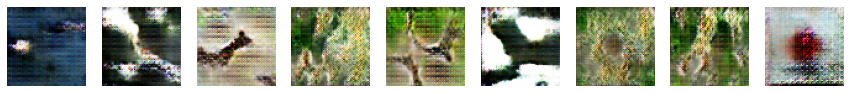

[ 4494 10123 11117   891 10452  1919  6437  6087  6928]
0 Yellow_Throated_Vireo_0014_159709.jpg
1 Heermann_Gull_0098_45753.jpg
2 Florida_Jay_0008_64482.jpg
3 Anna_Hummingbird_0099_55916.jpg
4 Western_Gull_0021_54649.jpg
5 Nighthawk_0003_82827.jpg
6 Shiny_Cowbird_0085_796839.jpg
7 Brewer_Sparrow_0035_107509.jpg
8 Mallard_0095_76080.jpg
(9, 64, 64, 3)


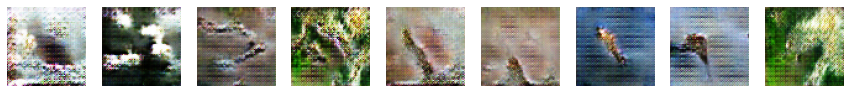

[ 3495  9488 11319  7358  9113 10855   859  7469  6544]
0 Red_Faced_Cormorant_0060_23416.jpg
1 Sooty_Albatross_0068_796353.jpg
2 Fox_Sparrow_0013_114344.jpg
3 Yellow_Bellied_Flycatcher_0055_795507.jpg
4 Magnolia_Warbler_0072_165534.jpg
5 Black_Throated_Sparrow_0099_106944.jpg
6 Anna_Hummingbird_0074_56917.jpg
7 White_Crowned_Sparrow_0090_125864.jpg
8 Vermilion_Flycatcher_0058_42311.jpg
(9, 64, 64, 3)


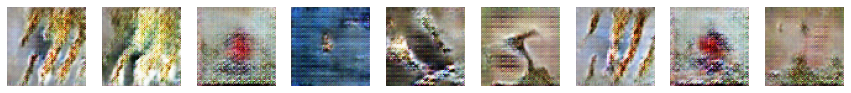

[ 4873 10457 10615  7444  1334  4273  8084  8939  6328]
0 Cactus_Wren_0075_186066.jpg
1 Western_Gull_0007_53431.jpg
2 Bank_Swallow_0040_129674.jpg
3 Horned_Grebe_0019_34811.jpg
4 Swainson_Warbler_0047_794870.jpg
5 Red_Cockaded_Woodpecker_0039_794736.jpg
6 Cedar_Waxwing_0057_178370.jpg
7 Gray_Catbird_0100_20674.jpg
8 Rufous_Hummingbird_0024_59636.jpg
(9, 64, 64, 3)


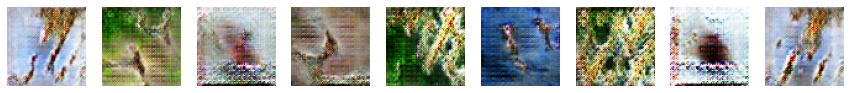

[11063  6809  3977   487  3531 10298  9342 10066  4904]
0 Western_Meadowlark_0018_77880.jpg
1 American_Pipit_0058_100218.jpg
2 Brandt_Cormorant_0003_22922.jpg
3 Red_Winged_Blackbird_0044_5621.jpg
4 Red_Faced_Cormorant_0063_796284.jpg
5 Savannah_Sparrow_0043_119362.jpg
6 Palm_Warbler_0089_168968.jpg
7 Purple_Finch_0043_28117.jpg
8 Song_Sparrow_0042_121314.jpg
(9, 64, 64, 3)


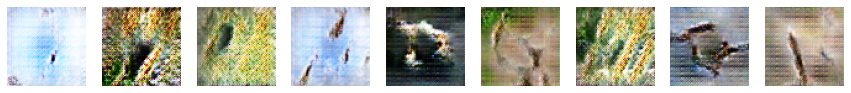

[2083 8671 8082 4683 1512 4599 4750 3420 7518]
0 White_Breasted_Kingfisher_0096_73552.jpg
1 Pigeon_Guillemot_0072_39905.jpg
2 Cedar_Waxwing_0113_178627.jpg
3 Blue_Winged_Warbler_0053_161896.jpg
4 Canada_Warbler_0087_162342.jpg
5 Glaucous_Winged_Gull_0005_44860.jpg
6 Wilson_Warbler_0020_175505.jpg
7 Brown_Thrasher_0057_155164.jpg
8 Cardinal_0016_17862.jpg
(9, 64, 64, 3)


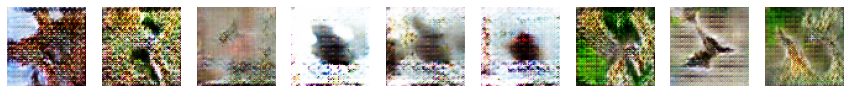

[10421  6608  7119  7996  5025  8845  7600 10305  2730]
0 Western_Gull_0099_53670.jpg
1 Gadwall_0066_31557.jpg
2 Indigo_Bunting_0085_11991.jpg
3 Downy_Woodpecker_0096_184532.jpg
4 Groove_Billed_Ani_0091_1728.jpg
5 American_Three_Toed_Woodpecker_0008_179850.jpg
6 Boat_Tailed_Grackle_0040_33417.jpg
7 Savannah_Sparrow_0009_120205.jpg
8 Common_Tern_0115_149482.jpg
(9, 64, 64, 3)


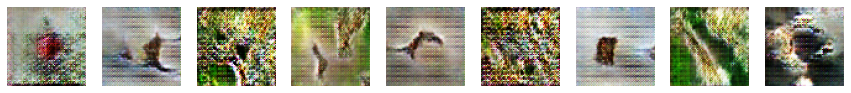

[ 3814   368 11653  8723  5343  9837  4872  5424  9389]
0 Philadelphia_Vireo_0008_156551.jpg
1 Prairie_Warbler_0058_172573.jpg
2 Green_Violetear_0028_60800.jpg
3 Black_Throated_Blue_Warbler_0137_161207.jpg
4 Orange_Crowned_Warbler_0057_168424.jpg
5 Nelson_Sharp_Tailed_Sparrow_0039_118074.jpg
6 Cactus_Wren_0036_185563.jpg
7 Warbling_Vireo_0030_158488.jpg
8 Palm_Warbler_0110_169490.jpg
(9, 64, 64, 3)


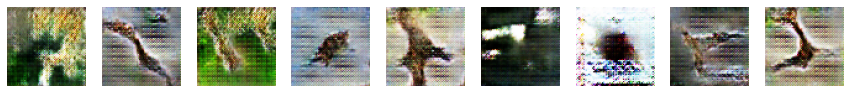

[ 1288   314  5230 11275  2369  5398  1017  9446   157]
0 Le_Conte_Sparrow_0088_117040.jpg
1 Grasshopper_Sparrow_0017_115908.jpg
2 Ovenbird_0034_93006.jpg
3 Bohemian_Waxwing_0099_177747.jpg
4 Worm_Eating_Warbler_0101_795557.jpg
5 Warbling_Vireo_0004_158376.jpg
6 Tree_Swallow_0091_136870.jpg
7 Rhinoceros_Auklet_0011_797530.jpg
8 Clark_Nutcracker_0011_85698.jpg
(9, 64, 64, 3)


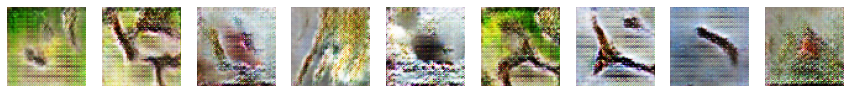

[ 4909  1519 10033 11568  2564  5013  2973  5281  9166]
0 Song_Sparrow_0034_121255.jpg
1 Canada_Warbler_0090_162432.jpg
2 Red_Headed_Woodpecker_0081_182811.jpg
3 Baird_Sparrow_0011_794577.jpg
4 Black_Capped_Vireo_0039_797451.jpg
5 Groove_Billed_Ani_0065_1502.jpg
6 Bronzed_Cowbird_0040_24134.jpg
7 White_Eyed_Vireo_0115_158932.jpg
8 Red_Breasted_Merganser_0024_79483.jpg
(9, 64, 64, 3)


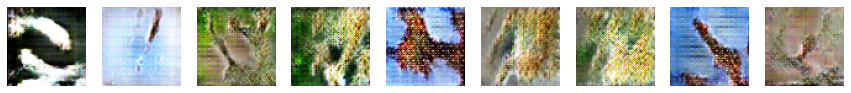

[ 9683   460 11144 11401  4650  9848  7213 10962  2117]
0 Eastern_Towhee_0030_22693.jpg
1 Seaside_Sparrow_0013_796535.jpg
2 American_Crow_0027_25146.jpg
3 Marsh_Wren_0110_188434.jpg
4 Glaucous_Winged_Gull_0015_44198.jpg
5 Nelson_Sharp_Tailed_Sparrow_0008_796944.jpg
6 Lincoln_Sparrow_0022_117759.jpg
7 Long_Tailed_Jaeger_0057_797094.jpg
8 White_Breasted_Kingfisher_0063_73365.jpg
(9, 64, 64, 3)


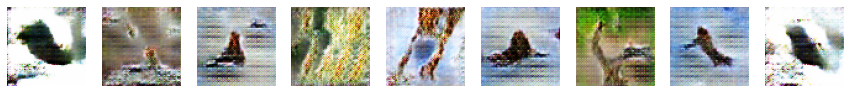

[10610  7505  4343   188  7459 10724  8882  6079  7928]
0 Bank_Swallow_0054_129743.jpg
1 White_Crowned_Sparrow_0111_127404.jpg
2 Black_Tern_0096_143917.jpg
3 Artic_Tern_0036_142447.jpg
4 White_Crowned_Sparrow_0140_125967.jpg
5 Evening_Grosbeak_0031_37239.jpg
6 Bewick_Wren_0085_185474.jpg
7 Brewer_Sparrow_0037_107442.jpg
8 White_Throated_Sparrow_0107_129046.jpg
(9, 64, 64, 3)


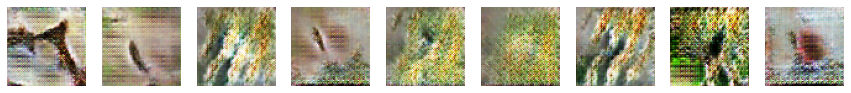

[ 8234  6521  3919  2903  1787  5380  6360  2919 10814]
0 Kentucky_Warbler_0067_165404.jpg
1 Vermilion_Flycatcher_0019_42241.jpg
2 Yellow_Billed_Cuckoo_0049_26766.jpg
3 Tennessee_Warbler_0049_175006.jpg
4 Brewer_Blackbird_0131_2289.jpg
5 Warbling_Vireo_0086_158564.jpg
6 Rufous_Hummingbird_0002_58387.jpg
7 Tennessee_Warbler_0021_174761.jpg
8 Caspian_Tern_0029_147589.jpg
(9, 64, 64, 3)


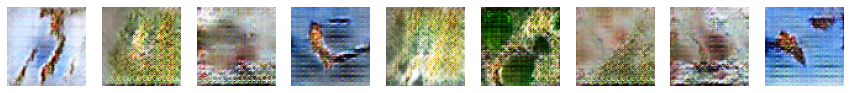

[6145 7714 1575 5840 6146 8493  949 1600 6183]
0 Gray_Kingbird_0037_70050.jpg
1 Pied_Kingfisher_0019_72659.jpg
2 Spotted_Catbird_0014_19425.jpg
3 Belted_Kingfisher_0006_70625.jpg
4 Gray_Kingbird_0056_70156.jpg
5 Northern_Flicker_0094_28726.jpg
6 Yellow_Headed_Blackbird_0086_8487.jpg
7 Northern_Fulmar_0028_43752.jpg
8 Gray_Kingbird_0003_70305.jpg
(9, 64, 64, 3)


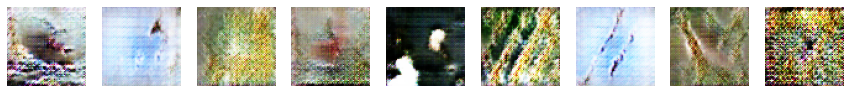

[ 2867  1980  3515  2118 11001  6862  3480  3784  9843]
0 Scarlet_Tanager_0079_138669.jpg
1 Tropical_Kingbird_0116_69714.jpg
2 Red_Faced_Cormorant_0009_796314.jpg
3 White_Breasted_Kingfisher_0087_73264.jpg
4 Long_Tailed_Jaeger_0059_797079.jpg
5 Chestnut_Sided_Warbler_0104_163638.jpg
6 Harris_Sparrow_0016_116661.jpg
7 Philadelphia_Vireo_0038_794759.jpg
8 Nelson_Sharp_Tailed_Sparrow_0014_796906.jpg
(9, 64, 64, 3)


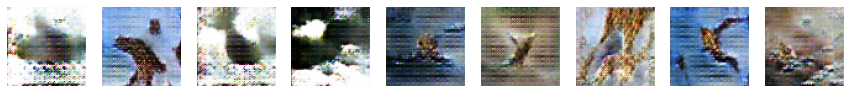

[10974 10569 11563  3579  6717  4780  3730  7842 10874]
0 Long_Tailed_Jaeger_0054_797088.jpg
1 Pied_Billed_Grebe_0005_35437.jpg
2 Baird_Sparrow_0003_794558.jpg
3 Vesper_Sparrow_0070_125555.jpg
4 Frigatebird_0091_43066.jpg
5 Lazuli_Bunting_0086_14992.jpg
6 Scissor_Tailed_Flycatcher_0059_41998.jpg
7 Chuck_Will_Widow_0058_796999.jpg
8 Black_Throated_Sparrow_0040_107172.jpg
(9, 64, 64, 3)


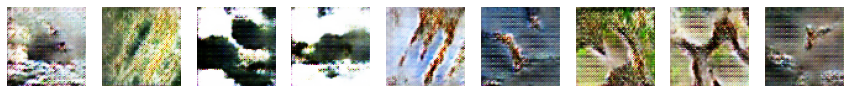

[ 9413  3644   904  9384  7815  4953  8541  2489 11201]
0 Rhinoceros_Auklet_0016_2114.jpg
1 Loggerhead_Shrike_0007_106101.jpg
2 Yellow_Headed_Blackbird_0070_8583.jpg
3 Palm_Warbler_0024_170501.jpg
4 Chuck_Will_Widow_0019_22806.jpg
5 Rock_Wren_0023_189075.jpg
6 Western_Grebe_0048_36399.jpg
7 Painted_Bunting_0013_15294.jpg
8 Great_Crested_Flycatcher_0097_29398.jpg
(9, 64, 64, 3)


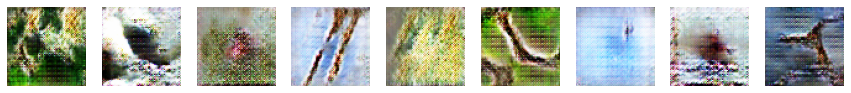

[ 8715  2438 11440  6139  1310  5004 10055  2185 11620]
0 Black_Throated_Blue_Warbler_0130_161682.jpg
1 Blue_Headed_Vireo_0025_156439.jpg
2 American_Goldfinch_0086_31887.jpg
3 Gray_Kingbird_0016_70288.jpg
4 Swainson_Warbler_0037_174691.jpg
5 Rock_Wren_0038_189328.jpg
6 Purple_Finch_0079_27258.jpg
7 Rusty_Blackbird_0096_6846.jpg
8 Green_Violetear_0092_795704.jpg
(9, 64, 64, 3)


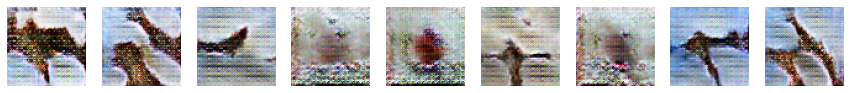

[ 7923 10910   894  7954  3028 11024  5147  2737  5481]
0 White_Throated_Sparrow_0063_128803.jpg
1 Louisiana_Waterthrush_0078_177444.jpg
2 Yellow_Headed_Blackbird_0109_8271.jpg
3 White_Throated_Sparrow_0034_129054.jpg
4 Black_Billed_Cuckoo_0088_26217.jpg
5 Western_Meadowlark_0028_78487.jpg
6 Hooded_Merganser_0049_79136.jpg
7 Common_Tern_0100_149541.jpg
8 Prothonotary_Warbler_0066_174318.jpg
(9, 64, 64, 3)


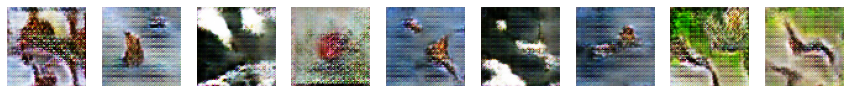

[ 4351  8586  3243 10880 10101  7194  6708  2360  8485]
0 Black_Tern_0104_144038.jpg
1 Pacific_Loon_0063_75865.jpg
2 Rose_Breasted_Grosbeak_0088_39035.jpg
3 Black_Throated_Sparrow_0056_107010.jpg
4 Purple_Finch_0104_28088.jpg
5 Laysan_Albatross_0075_668.jpg
6 Frigatebird_0122_43549.jpg
7 Chipping_Sparrow_0090_14718.jpg
8 Northern_Flicker_0132_28313.jpg
(9, 64, 64, 3)


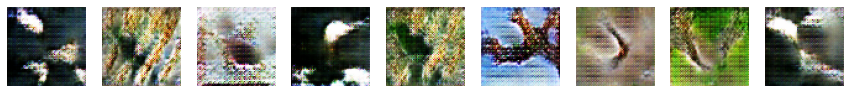

[11137  2327  8728  1038  5973  2344  6384  4318  9398]
0 American_Crow_0062_25587.jpg
1 Chipping_Sparrow_0032_108882.jpg
2 Black_Throated_Blue_Warbler_0085_161621.jpg
3 Tree_Swallow_0023_135345.jpg
4 Red_Legged_Kittiwake_0014_795432.jpg
5 Chipping_Sparrow_0071_108735.jpg
6 Western_Wood_Pewee_0008_795043.jpg
7 Black_Tern_0082_144372.jpg
8 Palm_Warbler_0046_169837.jpg
(9, 64, 64, 3)


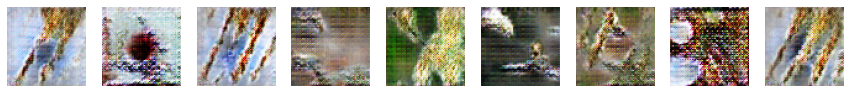

[  511  3433  4813  1571   111  4367  1985  2653 10508]
0 Red_Winged_Blackbird_0023_5257.jpg
1 Harris_Sparrow_0023_116363.jpg
2 Lazuli_Bunting_0048_14844.jpg
3 Spotted_Catbird_0042_19430.jpg
4 Brown_Pelican_0111_93872.jpg
5 Black_Tern_0041_144103.jpg
6 Tropical_Kingbird_0086_69759.jpg
7 Black_And_White_Warbler_0022_160512.jpg
8 Red_Eyed_Vireo_0043_157162.jpg
(9, 64, 64, 3)


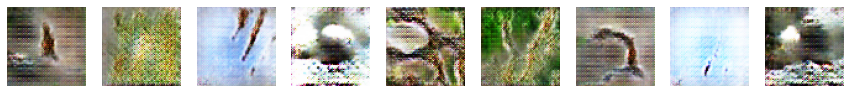

In [ ]:
#
from keras.preprocessing.image import array_to_img

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy import asarray
import numpy as np

import os
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from numpy.random import random
from tensorflow.keras import layers
from tensorflow.keras import Model
from numpy.random import randn
from numpy.random import randint
import time
import matplotlib.pyplot as pyplot
from keras.preprocessing.image import array_to_img
from numpy import linspace
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from numpy.random import randint
import numpy as np

def create_sent_vector(sent):
  result_array = np.empty((0, 300))

  for word in word_tokenize(sent):
    result_array = np.append(result_array, [model[word]], axis=0)
  final = np.mean(result_array, axis=0).astype('float32')
  return final

def generate_random_word_vectors_from_dataset(n_samples, create_new_captions = False):

  if create_new_captions:
      e = create_sent_vector('This bird has  white breast with brown feathers')
      f = create_sent_vector('This bird has  white breast with blue feathers')
      v = []
      flag = False
      for i in range(n_samples):
        
        if not flag:
          v.append(f)
          flag = True
        elif flag:
          v.append(e)
          flag = False
      return np.asarray(v), np.asarray([])
  else:
    ix = randint(0,len(captions), n_samples)
    print(ix)
    return  np.asarray(captions)[ix], np.asarray(labels)[ix]

def generate_images(model, test_input):

  predictions = model(test_input, training=False)

  print(predictions.shape)
  pyplot.figure(figsize=[15, 15])
  for i in range(predictions.shape[0]):
      pyplot.subplot(1, 9, i+1)
      pyplot.imshow(array_to_img(predictions.numpy()[i]))
      pyplot.axis('off')

  pyplot.show()

# Credit to: https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/
def interpolate_points(p1, p2, n_steps=9):
	ratios = linspace(0, 1, num=n_steps)
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)
 
def generate_latent_points(latent_dim, n_samples, interpolate = False):
    x_input  = tf.random.normal([n_samples, latent_dim])
    text_captions, labels = generate_random_word_vectors_from_dataset(n_samples, create_new_captions=False)
    if interpolate:
      text_captions = interpolate_points(text_captions[0], text_captions[1])
      x_input = interpolate_points(x_input[0], x_input[1])
    for index, s in enumerate(labels.flat):
      print(index, s)

    return [x_input, text_captions]

gen_model = tf.keras.models.load_model('/kaggle/input/bird70epochs/46stage_new_gan_animal_model_060.h5')

for i in range(40):
  generate_images(gen_model, generate_latent_points(100, 9))


In [ ]:
def get_index_by_label(label):
  for idx, l in enumerate(labels):
    if l in label:
      return idx


print(get_index_by_label('Western_Wood_Pewee_0061_795060.jpg'))

6399


(-0.5, 63.5, 63.5, -0.5)

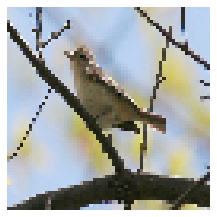

In [ ]:
# Show image in image embeddings

pyplot.figure(figsize=[8, 8])

pyplot.subplot(1, 2, 0+1)
pyplot.imshow(array_to_img(image_embeddings[5432]))
pyplot.axis('off')